## Exploratory Data Analysis and Clustering on the Wine Dataset (From Scratch)

### Introduction

This project showcases two major tasks common in data exploration:
1. **Principal Component Analysis (PCA):** Dimensionality reduction by finding directions (principal components) that capture the maximum variance in the dataset.
2. **_k_-Means Clustering:** A classic unsupervised algorithm that partitions data into a specified number of clusters by minimizing intra-cluster variance.

All steps, including creation of the data matrix, standardizing variables, constructing the covariance matrix, and implementing PCA and _k_-means, are done from scratch in NumPy to highlight the underlying mathematics.

### Data Overview and Loading

The Wine dataset contains information on various chemical and physical properties of wines from three different cultivars (types). Each wine sample is labeled as type 1, 2, or 3. Besides the type label, there are 13 other features, including quantities such as alcohol, malic acid, ash, alkalinity, magnesium, and so on.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2, linewidth=200)

# Reading the dataset
wine_data = pd.read_csv("/Users/kajizora/Desktop/School/portfolio_projects/wine_PCA_Kmeans/wine.csv")
print(wine_data.shape)
wine_data.head()

(178, 14)


,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735



The dataset has 178 samples (rows) and 14 columns (one for `Type` and 13 for various chemical measurements). The goal is to perform PCA on the 13 feature columns while treating `Type` as the categorical variable we might try to predict or understand in a clustering context.

---

### Constructing the Data Matrix

The first step is to create a NumPy matrix `X` that contains only the feature variables. We omit the `Type` column. In many data science settings, rows represent observations and columns represent features. Here, to align with certain mathematical conventions, each **column** of `X` represents a single observation, and each **row** represents one feature across all observations.


In [4]:

wine_data = pd.read_csv("/Users/kajizora/Desktop/School/portfolio_projects/wine_PCA_Kmeans/wine.csv")

# Extract all feature columns (omit the first column 'Type')
X = wine_data.iloc[:, 1:]
X = X.to_numpy()           # Convert to NumPy array
X = X.T                    # Transpose so each column is one observation

print("Shape of X:", X.shape)


Shape of X: (13, 178)




Here, `X` now has shape (13, 178): 13 variables/features (rows) and 178 observations (columns).

---

### Preprocessing (Mean-Centering and Scaling)

It is standard practice to mean-center and scale each feature to unit variance before performing PCA. For each variable (row in `X`), we subtract the mean and then divide by the standard deviation.

In [5]:

X_mean = np.mean(X, axis=1).reshape(13, 1)
X_centered = X - X_mean

X_var = np.var(X_centered, axis=1).reshape(13, 1)
SD = np.sqrt(X_var)
X_scaled = X_centered / SD

# Double-check that each feature now has variance 1
new_var = np.var(X_scaled, axis=1)
print("Variances after scaling:", new_var)


Variances after scaling: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


The output confirms each variable in `X_scaled` has variance close to 1.

---

### Covariance Matrix Construction

Next, we form the covariance matrix $C_X$ of the standardized data. This is done by
$$
C_X = \frac{1}{n-1} X_{\text{scaled}} \, X_{\text{scaled}}^T,
$$
where $n$ is the number of observations (in our case 178).

Diagonal of the covariance matrix: [1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01]


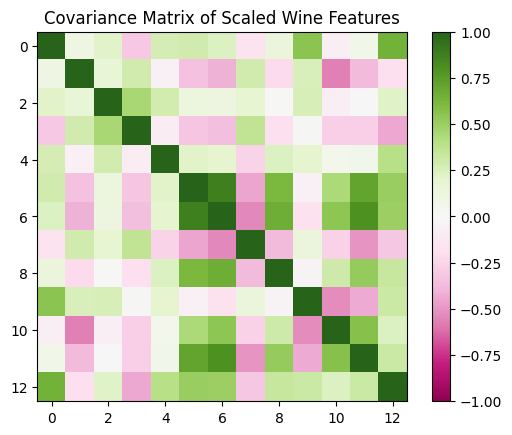

In [6]:

C_X = (1/(X_scaled.shape[1] - 1)) * np.dot(X_scaled, X_scaled.T)

# Confirm that diagonal elements (variances) are approximately 1
print("Diagonal of the covariance matrix:", np.diag(C_X))

plt.imshow(C_X, cmap="PiYG", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Covariance Matrix of Scaled Wine Features")
plt.show()




The diagonal values are approximately 1, matching our preprocessing step. The off-diagonal elements visualize pairwise covariances between features, with red/green hues indicating the sign and magnitude of correlations.

---

### Diagonalization and PCA Transformation

To perform PCA, we diagonalize $C_X$. This means finding an orthogonal matrix $Q$ (eigenvectors) and a diagonal matrix $\Lambda$ (eigenvalues) such that
$$
C_X = Q \Lambda Q^T.
$$
NumPy provides a function `np.linalg.eigh` that returns eigenvalues and eigenvectors of a symmetric matrix, which we sort in descending order:



In [7]:

eigenvalues, eigenvectors = np.linalg.eigh(C_X)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

Q = eigenvectors
D = np.diag(eigenvalues)

# Validation of the diagonalization
diff = np.linalg.norm(np.dot(np.dot(Q.T, C_X), Q) - D)
print("Norm of the difference (Q^T C_X Q - D):", diff)


Norm of the difference (Q^T C_X Q - D): 4.670066350791179e-15


After diagonalizing, we construct the transformation matrix $P = Q^T$. Multiplying our scaled data by $P$ gives the matrix $Y$ of principal component scores:

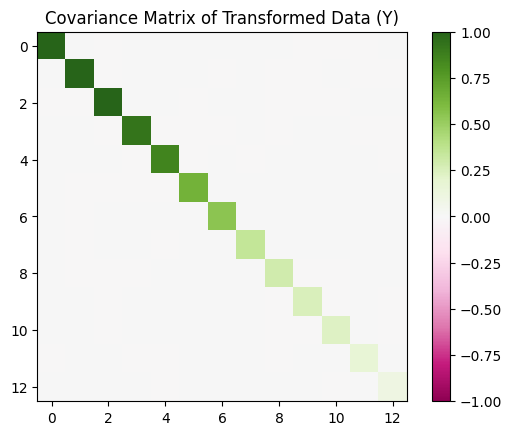

In [8]:
P = Q.T
Y = np.dot(P, X_scaled)

# Covariance of Y should be diagonal
C_Y = np.dot(np.dot(P, C_X), P.T)
plt.imshow(C_Y, cmap="PiYG", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Covariance Matrix of Transformed Data (Y)")
plt.show()



The off-diagonal elements in $C_Y$ are now (approximately) zero, indicating that the new features (principal components) are uncorrelated.

---

### Alternative PCA via SVD

We can obtain the same PCA result via the Singular Value Decomposition (SVD) of the scaled data matrix. SVD factorizes $X_{\text{scaled}}$ as
$$
X_{\text{scaled}} = U \Sigma V^T,
$$
where columns of $U$ contain the principal directions, and the singular values in $\Sigma$ relate directly to the eigenvalues of the covariance matrix.

In [9]:
U, S, Vt = np.linalg.svd(X_scaled)
# The transformed coordinates are U^T X_scaled
Y_SVD = np.dot(U.T, X_scaled)

# Variances of new components from singular values
C_Y_SVD = (1 / (X_scaled.shape[1] - 1)) * np.square(S)
print("Variance of new components from SVD:", C_Y_SVD)

Variance of new components from SVD: [4.73 2.51 1.45 0.92 0.86 0.65 0.55 0.35 0.29 0.25 0.23 0.17 0.1 ]




Eigenvalues from $C_X$ match the squares of singular values in $\Sigma$.

---

### Explained Variance

Each principal component has an associated variance (its eigenvalue). The sum of all eigenvalues equals the total variance. We often want to see how much of the total variance is captured by the first few principal components.

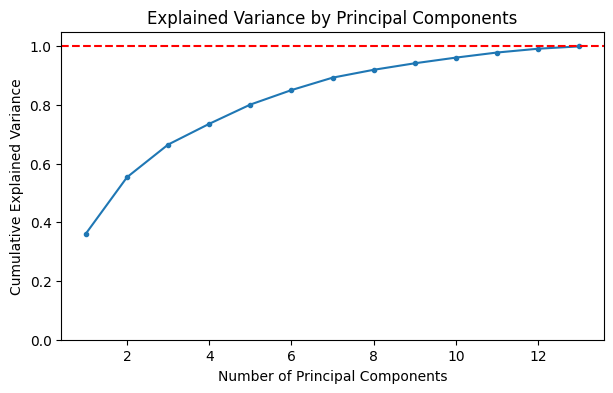

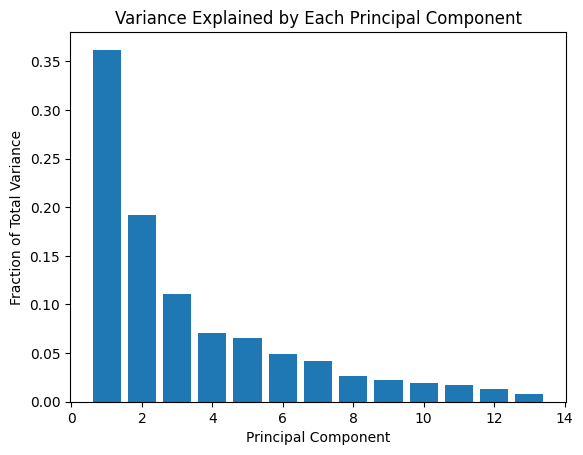

In [10]:

total_variance = np.sum(eigenvalues)
explained_variance_fraction = np.cumsum(eigenvalues) / total_variance

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, 14), explained_variance_fraction, ".-")
plt.ylim(0, 1.05)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.axhline(1.0, color="red", linestyle="--")
plt.show()

# Bar chart of each principal component's fraction of total variance
var_frac = eigenvalues / total_variance
plt.bar(np.arange(1, 14), var_frac)
plt.xlabel("Principal Component")
plt.ylabel("Fraction of Total Variance")
plt.title("Variance Explained by Each Principal Component")
plt.show()



---

### _k_-Means Clustering from Scratch

After performing PCA, we explore _k_-means clustering **without** using any standard libraries. The algorithm attempts to group our data points into $k$ clusters by minimizing the sum of squared distances to cluster centroids.

The data for clustering will come from the first two principal components of $Y$. Below are helper functions, each built from scratch.

#### Computing Centroids



In [11]:

def compute_centroids(coords, clusters):
    d, n = coords.shape
    k = len(clusters)
    centroids = np.zeros((d, k))
    for i in range(k):
        cluster_indices = clusters[i]
        if len(cluster_indices) == 0:
            continue
        cluster_points = coords[:, cluster_indices]
        centroids[:, i] = np.average(cluster_points, axis=1)
    return centroids


#### Assigning Points to Nearest Centroid

In [12]:

def closest_point_clustering(coords, centroids):
    d, n = coords.shape
    k = centroids.shape[1]
    clusters = [[] for _ in range(k)]
    for i in range(n):
        dists = np.linalg.norm(coords[:, i].reshape(d, 1) - centroids, axis=0)
        closest = np.argmin(dists)
        clusters[closest].append(i)
    return clusters


#### Computing the Total Clustering Distance

In [13]:

def compute_distance(coords, clusters, centroids):
    D = 0.0
    for i, cluster_indices in enumerate(clusters):
        if len(cluster_indices) > 0:
            cluster_points = coords[:, cluster_indices]
            distances = np.linalg.norm(cluster_points - centroids[:, i].reshape(-1, 1), axis=0)
            D += np.sum(distances**2)
    return D


#### Putting It All Together: _k_-Means

In [14]:

def random_starting_points(num_clus, coords):
    d = coords.shape[0]
    mins = np.min(coords, axis=1)
    maxs = np.max(coords, axis=1)
    np.random.seed(0)  # For reproducibility
    random_points = np.array([[np.random.uniform(mins[i], maxs[i]) for _ in range(num_clus)] 
                              for i in range(d)])
    return random_points

def k_means(num_clus, coords):
    centroids = random_starting_points(num_clus, coords)
    tol = 1e-5
    D_old = float('inf')
    max_iterations = 100
    
    for iteration in range(max_iterations):
        clusters = closest_point_clustering(coords, centroids)
        centroids = compute_centroids(coords, clusters)
        D_new = compute_distance(coords, clusters, centroids)
        
        if abs(D_old - D_new) < tol:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break
        D_old = D_new
    else:
        print(f"Reached maximum of {max_iterations} iterations without convergence.")
    
    return clusters, centroids


This iterative process continues until the total distance $D$ stabilizes (changing by less than $10^{-5}$) or we hit a maximum number of iterations.

---

### Clustering the Wine Data in Two Principal Components

We take the first two principal components from our PCA result (`Y[0]` and `Y[1]`) as coordinates for each data point, then perform _k_-means with $k=3$.

Convergence reached after 7 iterations.


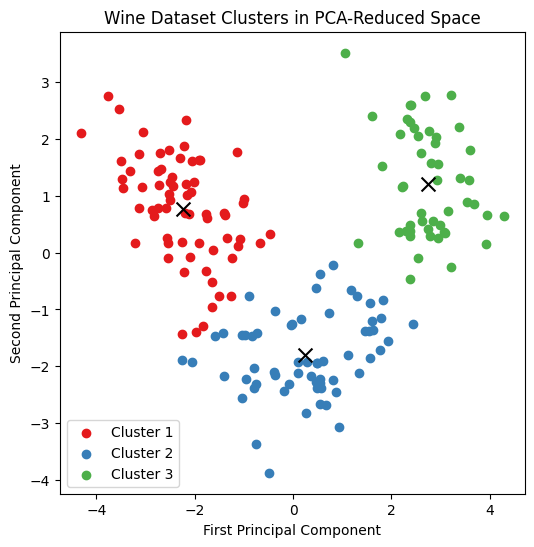

In [15]:
coords = np.array([Y[0], Y[1]])
clusters, centroids = k_means(num_clus=3, coords=coords)

plt.figure(figsize=(6, 6))
for i, cluster_indices in enumerate(clusters):
    cluster_points = coords[:, cluster_indices]
    plt.scatter(cluster_points[0], cluster_points[1], color=plt.cm.Set1(i), label=f'Cluster {i+1}')
for i, c in enumerate(centroids.T):
    plt.scatter(c[0], c[1], color='black', marker='x', s=100)

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Wine Dataset Clusters in PCA-Reduced Space")
plt.legend()
plt.show()



We observe three distinct clusters in the reduced two-dimensional PCA space.

---

### Evaluating the Clustering Against the True Wine Types

Although _k_-means is an unsupervised method, we know the true wine types (`Type` = 1, 2, or 3). We can check how well our clusters align with these true labels.

In [16]:
def summarize_unique(x):
    vals, counts = np.unique(x, return_counts=True)
    for v, c in zip(vals, counts):
        print(f"Value: {v}, Count: {c}")

for i, cluster_indices in enumerate(clusters):
    print(f"Cluster {i+1} Summary:")
    cluster_types = wine_data["Type"][cluster_indices]
    summarize_unique(cluster_types.values)
    print()

Cluster 1 Summary:
Value: 1, Count: 59
Value: 2, Count: 8

Cluster 2 Summary:
Value: 2, Count: 62

Cluster 3 Summary:
Value: 2, Count: 1
Value: 3, Count: 48




The output shows how many of each true type fell into each cluster. If the clusters align strongly with the wine types, we see a clear overlap (i.e., one cluster might contain mostly Type 1, another mostly Type 2, etc.). In practice, there's often some overlap or misclassification due to shared chemical profiles among the wine types.

---

### Conclusion

This project demonstrated a from-scratch approach to principal component analysis and _k_-means clustering using only NumPy for numerical operations. The **Wine dataset** served as a concise example of how PCA can be used for dimensionality reduction before clustering, showing how data tends to group naturally in the space spanned by the first two principal components. 

By implementing the algorithms manually, we gain a deeper understanding of each step: constructing the covariance matrix, extracting eigenvalues/eigenvectors, applying the SVD, and following the iterative updates of _k_-means. This type of hands-on development is useful for appreciating the inner workings of machine learning pipelines and can be extended or modified for other datasets and tasks.
